In [2]:
# prepare libraries
import networkx as nx
import pandas as pd
import numpy as np
from urllib import request # read files
import re
import os
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.corpus import state_union
from nltk.corpus import brown
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import words
from ast import literal_eval # transform data type
from collections import Counter
from wordcloud import WordCloud, STOPWORDS # wordcloud
import json # parse json file

In [3]:
df_characters = pd.read_csv("./ZeldaBotW_nodes_w_attributes_enriched.csv")
name_lst = list(df_characters.Name)

# Part A: Communities TF-IDF word-clouds

## _Exercise 1_
### calculating at the TF list for each community.
Use the same code you've written in ex. 7.

In [5]:
undir_larG = nx.read_gpickle("./zelda_undirGCC.pkl")

**Get communities**

In [6]:
import community.community_louvain as community_louvain
partition = community_louvain.best_partition(undir_larG)

size = float(len(set(partition.values())))
pos = nx.spring_layout(undir_larG)
count = 0.
# bulid a list contains graphs of each community.
btow_communities = []
for com in set(partition.values()) :
    count = count + 1.
    # get characters in the same community
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    # append each community's graph to the list
    btow_communities.append(undir_larG.subgraph(list_nodes))

**Creating Nc documents**<br>
(Nc:the number of communities have found)

Dictionaries we need:
1. key: characters, value: description tokens
2. key: communities, value: description tokesn This can be achieved by graphs.

In [44]:
# count TF of given graph and return a list


**Find the top 5 terms within each community.**

### calculate IDF for every word in every list 

# Part B - Topic Modeling

# Part C - Sentiment analysis

## Exercise 4: Dictionary-based sentiment within the communities data.

**Explaintion**
A dataset containing words, average happiness score (polarity), standard deviations, and rankings.
* word. The word.
* happiness_rank. Happiness ranking of words based on average happiness scores.
* happiness_average. Average happiness score.
* happiness_standard_deviation. Standard deviations of the happiness scores.
* twitter_rank. Twitter ranking of the word.
* google_rank. Google ranking of the word.
* nyt_rank. New York Times ranking of the word.
* lyrics_rank. lyrics ranking of the word.

In [7]:
labMIT = pd.read_csv('./LabMIT-1.0.txt',header=2,sep='\t')
labMIT.head()

,word,happiness_rank,happiness_average,happiness_standard_deviation,twitter_rank,google_rank,nyt_rank,lyrics_rank
0,laughter,1,8.50,0.9313,3600,--,--,1728
1,happiness,2,8.44,0.9723,1853,2458,--,1230
2,love,3,8.42,1.1082,25,317,328,23
3,happy,4,8.30,0.9949,65,1372,1313,375
4,laughed,5,8.26,1.1572,3334,3542,--,2332


In [8]:
# read file
with open('CharactersDialogue.json',mode='r',encoding='utf-8') as f:
    text = f.read()

# parse file
dialogues = json.loads(text)

**`dialogues` is a dictionary with character names as key and their dialogues(list) as value**

In [9]:
# Preprocess: get rid of weird letters
for key,value in dialogues.items():
    for i,sentence in enumerate(value):
        value[i] = re.sub("[^a-zA-Z0-9， \，\']+", "",sentence)

In [10]:
print(len(dialogues),'characters have dialogues')

475 characters have dialogues


Not all characters in the network have data (especially enemies and bosses). Thus, **we will consider just communities with nodes having some dialogue in the following.**

###  calculates sentiment given a list of tokens

In [11]:
# get a name list so to exclude them in our text
# collecting names with word_tokenize which will differentiate first name and second name while remaining special characters
splited_name_lst = []
for i in name_lst:
    tokens = nltk.word_tokenize(i)
    if len(tokens) < 4:
        splited_name_lst.extend(tokens)
    # for names with '()' e.g. XXX(Breath of the wind),XXX(Hylian)
    elif '(' in tokens:
        if len(tokens) > 6:
            splited_name_lst.extend(tokens[0:-6])
        else:
            splited_name_lst.extend(tokens[0:-3])

In [12]:
# def a function that calculates sentiment given a list of tokens
def calculate_sentiment(dialogue_list):
    # Firstly,turn dialogue lists to tokens——这部分可以拿出来见get_dialogue_tokens()
    # Step1: tokenize the sentences.
    # combine each list element to text, seperated with space
    raw_tokens = nltk.wordpunct_tokenize(' '.join(dialogue_list))
    # exclude names
    name_excluded_tokens = [i for i in raw_tokens if i.lower() not in splited_name_lst]
    # Step2: lemmatize
    wnl = nltk.WordNetLemmatizer()
    stpwds = stopwords.words('english')
    lemma_dialogues = [wnl.lemmatize(t) for t in name_excluded_tokens \
                           if t.lower() not in stpwds and t.isalpha()]
    # Step3: set each token to lower case
    lower_dialogues = [w.lower() for w in lemma_dialogues]
    
    # Secondly, calculate sentiment based on LabMIT
    # Step1: generate a freq dict of these tokens
    fdist = nltk.FreqDist(nltk.Text(lower_dialogues))
    # Step2: match existing tokens in labMIT txt so to calculate sentiment score
    dict_sentiment = {}
    for token in fdist.keys():
        if token in labMIT['word'].values:
            # calculate each token's sentiment score and save word with it to our dict
            # get corresponding word's happiness_average score within labMIT df
            weights = fdist[token]
            score = float(labMIT.happiness_average[labMIT['word'].isin([token])])
            dict_sentiment[token] = weights*score
            
    # calculate weighted mean of sentiment for all tokens
    weighted_mean = sum(dict_sentiment.values())/len(lower_dialogues)
    return weighted_mean

In [ ]:
# enter a list of dialogues return its processed token list
def get_dialogue_tokens():
    # Firstly,turn dialogue lists to tokens — 这个部分可以拿出来单独设一个更方便,见3.3.1
    # Step1: tokenize the sentences.
    # combine each list element to text, seperated with space
    raw_tokens = nltk.wordpunct_tokenize(' '.join(dialogue_list))
    # exclude names
    name_excluded_tokens = [i for i in raw_tokens if i.lower() not in splited_name_lst]
    # Step2: lemmatize
    wnl = nltk.WordNetLemmatizer()
    stpwds = stopwords.words('english')
    lemma_dialogues = [wnl.lemmatize(t) for t in name_excluded_tokens \
                           if t.lower() not in stpwds and t.isalpha()]
    # Step3: set each token to lower case
    lower_dialogues = [w.lower() for w in lemma_dialogues]

### Iterate over the nodes in your network, tokenize each sentence, and calculate the average sentiment of every character.Have sentiment as a new nodal property.

In [13]:
# Iterate over the nodes in your network
for node in undir_larG.nodes():
    if node in dialogues.keys():
        # have sentiment as a new nodal property
        undir_larG.add_node(node,\
                            sentiment=calculate_sentiment(dialogues[node]))

**Since we add new attribute to our nodes so we need to reload communities as well to update nodes attributes within our communities**

In [16]:
import community.community_louvain as community_louvain
partition = community_louvain.best_partition(undir_larG)

count = 0.
# bulid a list contains graphs of each community.
btow_communities = []
for com in set(partition.values()) :
    count = count + 1.
    # get characters in the same community
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    # append each community's graph to the list
    btow_communities.append(undir_larG.subgraph(list_nodes))

### Create a histogram of all character's associated dialogue-sentiments.

Text(0.5, 0, 'character counts')

<Figure size 1080x720 with 0 Axes>

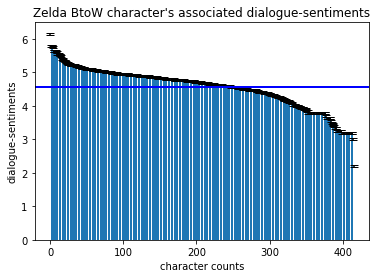

In [19]:
y = np.array(list((btow_sentiment).values()))
x = range(len(btow_sentiment))

plt.figure(figsize=(15,10))
fig, ax = plt.subplots()
# add error bars 
std_error = np.std(y, ddof=1) / np.sqrt(len(y))
ax.bar(x=np.arange(len(y)), #x-coordinates of bars
       height=y, #height of bars
       yerr=std_error, #error bar width
       capsize=4) #length of error bar caps
# add average line
plt.axhline(y=y.mean(), color='blue', linewidth=2)
# add more details
plt.title('Zelda BtoW character\'s associated dialogue-sentiments')
plt.ylabel('dialogue-sentiments')
plt.xlabel('character counts')

### What are the 10 characters with happiest and saddest pages?


In [18]:
btow_sentiment = nx.get_node_attributes(undir_larG,'sentiment')
# sort sentiment from high to low
btow_sentiment = dict(sorted(btow_sentiment.items(), key=lambda x: x[1], reverse=True))

**The 10 characters with happiest pages**

In [21]:
top10_happiest_characters_labMIT = list(btow_sentiment.keys())[:10]
top10_happiest_characters_labMIT

['Toren',
 'Canni',
 'Breen',
 'Piaffe',
 'Shamae',
 'Kish',
 'Ozunda',
 'Padok',
 'Tulin',
 'Tenne']

**The 10 characters with saddest pages**

In [22]:
top10_saddest_characters_labMIT = list(btow_sentiment.keys())[-1:-11:-1]
top10_saddest_characters_labMIT

['Walton',
 'Palme',
 'Chaas Qeta',
 'Muwo Jeem',
 'Soh Kofi',
 'Mozo Shenno',
 'Hia Miu',
 'Goma Asaagh',
 'Sasa Kai',
 'Kema Kosassa']

### Create a bar plot showing the average sentiment of each community and add error-bars using the standard deviation for both methods.

**Firstly, we calculate the sentiment of each node in a community and average the sum to get a sentiment score for this community.**

In [52]:
sentiments_of_communities = {}
for i in range(len(btow_communities)):
    sum_sentiment = sum(nx.get_node_attributes(btow_communities[i],'sentiment').values())
    length = len(btow_communities[i].nodes())
    single_sentiment = sum_sentiment/length
    sentiments_of_communities[i] = single_sentiment

Text(0.5, 0, 'Community')

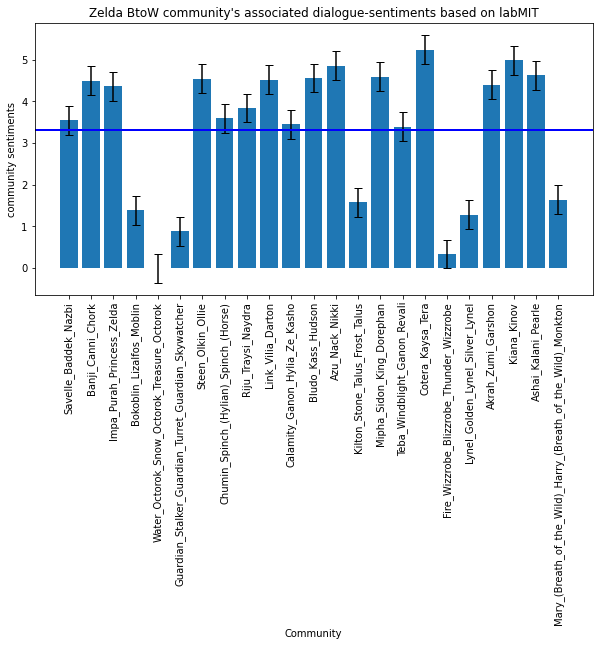

In [51]:
y = np.array(list((sentiments_of_communities).values()))
x = range(len(sentiments_of_communities))

fig, ax = plt.subplots(figsize=(10,5))
# add error bars 
std_error = np.std(y, ddof=1) / np.sqrt(len(y))
ax.bar(x=np.arange(len(y)), #x-coordinates of bars
       height=y, #height of bars
       yerr=std_error, #error bar width
       capsize=4) #length of error bar caps
# add average line
plt.axhline(y=y.mean(), color='blue', linewidth=2)
# add more details
# set xticks by community names which is defined in 3.1.6
plt.xticks([i for i in range(len(sentiments_of_communities))], communities_name, rotation = '90')
plt.title('Zelda BtoW community\'s associated dialogue-sentiments based on labMIT')
plt.ylabel('community sentiments')
plt.xlabel('Community')

### Name each community by its three most connected characters.

Previously, I have set my community number in a dictionary with its sentimnet score according to its index saved in the network subgraphs of communities. So we can continue indexing them by these numbers

In [25]:
# def a function to name a community by its three most connected characters(found by rank node degrees)
# parameter: the index number of a community within our btow network
def name_community(number):
    node_degrees = dict(sorted(btow_communities[number].degree(), key=lambda x: x[1], reverse=True))
    top3_connected_nodes = list(node_degrees.keys())[:3]
    name = '_'.join(top3_connected_nodes)
    # variable cannot be seperated by space
    if ' ' in name:
        name = name.replace(' ','_')
    return name

In [39]:
communities_name = []
for i in range(len(btow_communities)):
    communities_name.append(name_community(i))

In [27]:
# this list contains the name for all communities and it's order aligned with corresponding community index
communities_name[:10]

['Savelle_Baddek_Nazbi',
 'Banji_Canni_Chork',
 'Impa_Purah_Princess_Zelda',
 'Bokoblin_Lizalfos_Moblin',
 'Water_Octorok_Snow_Octorok_Treasure_Octorok',
 'Guardian_Stalker_Guardian_Turret_Guardian_Skywatcher',
 'Steen_Olkin_Ollie',
 'Chumin_Spinch_(Hylian)_Spinch_(Horse)',
 'Riju_Traysi_Naydra',
 'Link_Vilia_Darton']

In [45]:
# assign variable name to each community
count = 0
nm = locals()
for i in communities_name:
    nm[i] = btow_communities[count]
    count+=1

In [46]:
# Test: call community by its name
Kiana_Kinov # according to the output it's successful

### Top 3 happiest/saddest communities

In [36]:
# def a function to find variable name based on its value
def retrieve_name(var):
    import inspect
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    name_history = [var_name for var_name, var_val in callers_local_vars if var_val is var]
    latest_name = name_history[-1]
    return latest_name

In [55]:
# To get the happiest/saddest communities
# We can first sort our communityNo-sentiment dictionary from high to low
tempDict = dict(sorted(sentiments_of_communities.items(), key=lambda x: x[1], reverse=True))
# And then get their corresponding No.
hp_com = list(tempDict.keys())[0:3]
sd_com = list(tempDict.keys())[-1:-4:-1]

Now we can use the lists of coomunity numbers to query the top3 communities

**Top 3 happiest communities**

In [56]:
for i in hp_com:
    print('Community:',retrieve_name(btow_communities[i]))
    print(btow_communities[i].nodes(),'\n')

Community: Cotera_Kaysa_Tera
['Kaysa', 'Toren', 'Tera', 'Cotera'] 

Community: _46
['Kiana', 'Kinov'] 

Community: Azu_Nack_Nikki
['Sayge', 'Clavia', 'Nack', 'Narah', 'Karin', 'Teebo', 'Nebb', 'Pruce', 'Reede', 'Medda', 'Nikki', 'Ivee', 'Amira', 'Azu', 'Horned Statue', 'Sefaro', 'Senna', 'Aster'] 



**Top 3 saddest communities**

In [80]:
dialogues['Chuchu']

KeyError: 'Chuchu'

In [68]:
for i in sd_com:
    print('Community:',retrieve_name(btow_communities[i]))
    print(btow_communities[i].nodes(),'\n')

Community: Water_Octorok_Snow_Octorok_Treasure_Octorok
['Water Octorok', 'Snow Octorok', 'Treasure Octorok', 'Rock Octorok', 'Forest Octorok', 'Sky Octorok'] 

Community: Fire_Wizzrobe_Blizzrobe_Thunder_Wizzrobe
['Ice Keese', 'Ice Chuchu', 'Blizzrobe', 'Electric Chuchu', 'Fire Keese', 'Electric Keese', 'Glendo', 'Thunder Wizzrobe', 'Fire Wizzrobe', 'Meteo Wizzrobe', 'Fire Chuchu', 'Keese', 'Ice Wizzrobe', 'Electric Wizzrobe', 'Chuchu'] 

Community: Guardian_Stalker_Guardian_Turret_Guardian_Skywatcher
['Guardian Skywatcher', 'Guardian Scout IV', 'Garill', 'Guardian Turret', 'Decayed Guardian', 'Guardian Stalker', 'Guardian Scout III', 'Sentry', 'Guardian Scout II', 'Guardian Scout I', 'Brigo'] 



### Do these results confirm what you can learn about each community by skimming the wikipedia pages?

Normally, we can assume that allies are happier than enemies. So we can look at the ratio of allies/enemies in those top3 happies/saddest communities to figure out wether the communities aligned with our assumption.

In [48]:
allies = df_characters[df_characters['Role']=='Ally'].Name
avg_ratio = 0
for i in hp_com:
    common_allies = set(btow_communities[i].nodes()).intersection(set(allies))
    ratio = len(common_allies)/len(btow_communities[i].nodes())
    avg_ratio+=ratio
print(avg_ratio/3)

1.0


We can see that allies account for very high percentages(about 94%) among the top3 happies communities.

In [49]:
enemies = df_characters[df_characters['Role']=='Enemy'].Name
avg_ratio = 0
for i in sd_com:
    common_allies = set(btow_communities[i].nodes()).intersection(set(enemies))
    ratio = len(common_allies)/len(btow_communities[i].nodes())
    avg_ratio+=ratio
print(avg_ratio/3)

0.9171717171717172


We can see that enemies account for more than half (about 64%) among the top3 saddest communities.<br>
Basically, it's aligned with our assumption.

## Exercise 5: (dictionary & rule)-based sentiment within the communities data.

### Explore the VADER lexicon data.
**What are the top 10 words by polarity. And the bottom 10?**

In [578]:
# There is no header in txt we need to add it manually 
vader = pd.read_csv('./vader_lexicon.txt',sep='\t',
            header=None,names=['TOKEN', 'MEAN-SENTIMENT-RATING', 'STANDARD DEVIATION', 'RAW-HUMAN-SENTIMENT-RATINGS'])
vader.head()

,TOKEN,MEAN-SENTIMENT-RATING,STANDARD DEVIATION,RAW-HUMAN-SENTIMENT-RATINGS
0,$:,-1.5,0.80623,"[-1, -1, -1, -1, -3, -1, -3, -1, -2, -1]"
1,%),-0.4,1.01980,"[-1, 0, -1, 0, 0, -2, -1, 2, -1, 0]"
2,%-),-1.5,1.43178,"[-2, 0, -2, -2, -1, 2, -2, -3, -2, -3]"
3,&-:,-0.4,1.42829,"[-3, -1, 0, 0, -1, -1, -1, 2, -1, 2]"
4,&:,-0.7,0.64031,"[0, -1, -1, -1, 1, -1, -1, -1, -1, -1]"


**TOP 10 POSTITIVE TOKENS**

In [581]:
vader[['TOKEN', 'MEAN-SENTIMENT-RATING']].sort_values(\
                        by= 'MEAN-SENTIMENT-RATING',ascending=False).head()

,TOKEN,MEAN-SENTIMENT-RATING
271,ilu,3.4
273,ily,3.4
4551,magnificently,3.4
207,aml,3.4
6553,sweetheart,3.3


**TOP 10 NEGATIVE TOKENS**

In [582]:
vader[['TOKEN', 'MEAN-SENTIMENT-RATING']].sort_values(\
                        by= 'MEAN-SENTIMENT-RATING').head()

,TOKEN,MEAN-SENTIMENT-RATING
5478,rapist,-3.9
6105,slavery,-3.8
5477,raping,-3.8
4731,murder,-3.7
4262,kill,-3.7


VADER's mean-sentiment-rating ranges from -3.9 to 3.4,

**Plot the distribution of polarity according to the VADER Lexicon data.** What are the differences compared to the labMT data? Is it to be expected?

### Go through the example sentences in the vaderSentiment documentation page (Section Code Examples). Compute the compund polarity for each sentence.

In [588]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [87]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
#note: depending on how you installed (e.g., using source code download versus pip install), you may need to import like this:
#from vaderSentiment import SentimentIntensityAnalyzer

# --- examples -------
sentences = ["VADER is smart, handsome, and funny.",  # positive sentence example
             "VADER is smart, handsome, and funny!",  # punctuation emphasis handled correctly (sentiment intensity adjusted)
             "VADER is very smart, handsome, and funny.", # booster words handled correctly (sentiment intensity adjusted)
             "VADER is VERY SMART, handsome, and FUNNY.",  # emphasis for ALLCAPS handled
             "VADER is VERY SMART, handsome, and FUNNY!!!", # combination of signals - VADER appropriately adjusts intensity
             "VADER is VERY SMART, uber handsome, and FRIGGIN FUNNY!!!", # booster words & punctuation make this close to ceiling for score
             "VADER is not smart, handsome, nor funny.",  # negation sentence example
             "The book was good.",  # positive sentence
             "At least it isn't a horrible book.",  # negated negative sentence with contraction
             "The book was only kind of good.", # qualified positive sentence is handled correctly (intensity adjusted)
             "The plot was good, but the characters are uncompelling and the dialog is not great.", # mixed negation sentence
             "Today SUX!",  # negative slang with capitalization emphasis
             "Today only kinda sux! But I'll get by, lol", # mixed sentiment example with slang and constrastive conjunction "but"
             "Make sure you :) or :D today!",  # emoticons handled
             "Catch utf-8 emoji such as such as 💘 and 💋 and 😁",  # emojis handled
             "Not bad at all"  # Capitalized negation
             ]

analyzer = SentimentIntensityAnalyzer()
for sentence in sentences:
    vs = analyzer.polarity_scores(sentence)
    print("{:-<65} {}".format(sentence, str(vs)))

VADER is smart, handsome, and funny.----------------------------- {'neg': 0.0, 'neu': 0.254, 'pos': 0.746, 'compound': 0.8316}
VADER is smart, handsome, and funny!----------------------------- {'neg': 0.0, 'neu': 0.248, 'pos': 0.752, 'compound': 0.8439}
VADER is very smart, handsome, and funny.------------------------ {'neg': 0.0, 'neu': 0.299, 'pos': 0.701, 'compound': 0.8545}
VADER is VERY SMART, handsome, and FUNNY.------------------------ {'neg': 0.0, 'neu': 0.246, 'pos': 0.754, 'compound': 0.9227}
VADER is VERY SMART, handsome, and FUNNY!!!---------------------- {'neg': 0.0, 'neu': 0.233, 'pos': 0.767, 'compound': 0.9342}
VADER is VERY SMART, uber handsome, and FRIGGIN FUNNY!!!--------- {'neg': 0.0, 'neu': 0.294, 'pos': 0.706, 'compound': 0.9469}
VADER is not smart, handsome, nor funny.------------------------- {'neg': 0.646, 'neu': 0.354, 'pos': 0.0, 'compound': -0.7424}
The book was good.----------------------------------------------- {'neg': 0.0, 'neu': 0.508, 'pos': 0.492, 'co

Typical threshold values (used in the literature cited on this page) are:<br>

>1. positive sentiment: `compound` score >= 0.05
>2. neutral sentiment: (`compound` score > -0.05) and (`compound` score < 0.05)
>3. negative sentiment: `compound` score <= -0.05

### Try VADER on your own sentences. Can you find a sentence where VADER gets wrong (the polarity has opposite sign compared to what one would expect)? You can have a look at VADER set of rules in the paper linked above

In [615]:
wrong_sentence = ['You are damn right'] # to emphasize agreement can be positive
vs = analyzer.polarity_scores(wrong_sentence)
print("{} {}".format(wrong_sentence[0], str(vs)))

You are damn right {'neg': 0.474, 'neu': 0.526, 'pos': 0.0, 'compound': -0.4019}


In real social platforms or daily conversations, some comments or words can be negative or positive based on the context. VADER works well given enough sentences. However, if the input is quite short, VADER sometimes can't tell the real sentiment behind short sentences.

### Explain the difference between the two methods and compare the results you have obtained above.
What is the advantage of using a rule-based method over the dictionary-based approach?

1. VANDER combines lexical features with consideration for five general rules that embody grammatical and syntactical conventions for expressing and emphasizing sentiment intensity.

## Exercise 6: VADER and BotW Sentiment

Now use the BotW sentences from Exercise 4. Apply VADER to each individual sentence (i.e. list of tokens). Then compute the average polarity for each character. (hint remember that now it is important to keep punctuation, ALL-CAPS words, etc.)

### What are the 10 characters with happiest and saddest pages according to VADER?

In [88]:
vader_character_score = {}
# loop each characters
for i in dialogues.keys():
    sentences = dialogues[i]
    avg_vs = 0
    # calculate sentiment for each dialogue of this character
    sentence_count = 0
    for sentence in sentences:
        vs = analyzer.polarity_scores(sentence)
        # extract the compound score we only need it
        avg_vs+=vs['compound']
        sentence_count+=1
    vader_character_score[i] = avg_vs/sentence_count

We can transform the score dictionary to dataframe for convenience use.

In [89]:
# sort our dictionary based on compound value from high to low
vader_character_score = dict(sorted(vader_character_score.items(), key=lambda x: x[1], reverse=True))

**The 10 happiest characters**

In [90]:
top10_happiest_characters_vd = list(btow_sentiment.keys())[:10]
top10_happiest_characters_vd

['Toren',
 'Canni',
 'Breen',
 'Piaffe',
 'Shamae',
 'Kish',
 'Ozunda',
 'Padok',
 'Tulin',
 'Tenne']

In [91]:
# vader top10 characters intersection with labMIT 
inter_num = len(set(top10_happiest_characters_labMIT).intersection(set(top10_happiest_characters_vd)))
print('top10 happiest character based on labMIT','\n',top10_happiest_characters_labMIT)
print('They have',inter_num,'characters in common')

top10 happiest character based on labMIT 
 ['Toren', 'Canni', 'Breen', 'Piaffe', 'Shamae', 'Kish', 'Ozunda', 'Padok', 'Tulin', 'Tenne']
They have 10 characters in common


**The 10 saddest characters**

In [92]:
top10_saddest_characters_vd = list(btow_sentiment.keys())[-1:-11:-1]
top10_saddest_characters_vd

['Walton',
 'Palme',
 'Chaas Qeta',
 'Muwo Jeem',
 'Soh Kofi',
 'Mozo Shenno',
 'Hia Miu',
 'Goma Asaagh',
 'Sasa Kai',
 'Kema Kosassa']

In [85]:
# vader top10 characters intersection with labMIT 
inter_num = len(set(top10_saddest_characters_labMIT).intersection(set(top10_saddest_characters_vd)))
print('top10 happiest character based on labMIT','\n',top10_saddest_characters_labMIT)
print('They have',inter_num,'characters in common')

top10 happiest character based on labMIT 
 ['Walton', 'Palme', 'Chaas Qeta', 'Muwo Jeem', 'Soh Kofi', 'Mozo Shenno', 'Hia Miu', 'Goma Asaagh', 'Sasa Kai', 'Kema Kosassa']
They have 10 characters in common


They both identified the same top 10 happiest/saddest characters. But these characters present with different orders within two methods.

### Aggregate by community and compute the average community compund polarity. Create a bar plot showing the average compound polarity of each community and add error-bars using the standard deviation.

**Name each community by its three most connected characters.**

This has been done in 3.1.6

In [93]:
communities_name[:10]

['Savelle_Baddek_Nazbi',
 'Banji_Canni_Chork',
 'Impa_Purah_Princess_Zelda',
 'Bokoblin_Lizalfos_Moblin',
 'Water_Octorok_Snow_Octorok_Treasure_Octorok',
 'Guardian_Stalker_Guardian_Turret_Guardian_Skywatcher',
 'Steen_Olkin_Ollie',
 'Chumin_Spinch_(Hylian)_Spinch_(Horse)',
 'Riju_Traysi_Naydra',
 'Link_Vilia_Darton']

**What are the three happiest communities according to VADER?**

In [94]:
# Iterate over the nodes in your network
for node in undir_larG.nodes():
    if node in dialogues.keys():
        # have vader's compound value of each character as a new nodal property
        undir_larG.add_node(node,\
                            compound=vader_character_score[node])

# get a dictionary in which keys are the community no.,values are its compound value
vader_sentiments_of_communities = {}
for i in range(len(btow_communities)):
    sum_compound_value = sum(nx.get_node_attributes(btow_communities[i],'compound').values())
    length = len(btow_communities[i].nodes())
    avg_compound = sum_compound_value/length
    vader_sentiments_of_communities[i] = avg_compound

In [95]:
# To get the happiest/saddest communities
# We can first sort our communityNo-sentiment dictionary from high to low
tempDict = dict(sorted(vader_sentiments_of_communities.items(), key=lambda x: x[1], reverse=True))

# And then get their corresponding No.
hp_com_vader = list(tempDict.keys())[0:3]
sd_com_vader = list(tempDict.keys())[-1:-4:-1]

In [96]:
for i in hp_com_vader:
    print('Community:',retrieve_name(btow_communities[i]))
    print(btow_communities[i].nodes(),'\n')

Community: Calamity_Ganon_Hylia_Ze_Kasho
['Ze Kasho', 'Noya Neha', 'Katah Chuki', "Tu Ka'loh", 'Takama Shiri', 'Qaza Tokki', "Tahno O'ah", 'Rohta Chigah', 'Kihiro Moh', 'Tawa Jinn', 'Qukah Nata', 'Etsu Korima', "Korsh O'hu", 'Kiah Toza', 'Noe Rajee', 'Keeha Yoog', 'Dagah Keek', "Jitan Sa'mi", 'Dila Maag', 'Lanno Kooh', 'Raqa Zunzo', 'Suma Sahma', 'Katosa Aug', 'Shira Gomar', 'Keive Tala', 'Kema Kosassa', 'Tho Kayu', 'Shoqa Tatone', 'To Quomo', "Tena Ko'sah", 'Shai Yota', 'Muwo Jeem', 'Calamity Ganon', 'Ketoh Wawai', 'Yowaka Ita', 'Gorae Torr', 'Rona Kachta', 'Soh Kofi', 'Maag Halan', "Saas Ko'sah", 'Daag Chokah', "Maag No'rah", 'Tutsuwa Nima', 'Pumaag Nitae', 'Shae Katha', 'Ritaag Zumo', 'Namika Ozz', 'Sasa Kai', 'Goma Asaagh', 'Lakna Rokee', 'Hia Miu', 'Chaas Qeta', 'Mozo Shenno', 'Dah Kaso', 'Kuhn Sidajj', 'Zuna Kai', 'Misae Suma', 'Korgu Chideh', 'Kah Mael', "Ke'nai Shakah", 'Hylia', 'Mijah Rokee', 'Ruvo Korbah'] 

Community: Savelle_Baddek_Nazbi
['Yammo', 'Nazbi', 'Savelle', 'Daunt

**what are the three saddest communities according to VADER?**

In [97]:
for i in sd_com_vader:
    print('Community:',retrieve_name(btow_communities[i]))
    print(btow_communities[i].nodes(),'\n')

Community: Mary_(Breath_of_the_Wild)_Harry_(Breath_of_the_Wild)_Monkton
['Mary (Breath of the Wild)', 'Harry (Breath of the Wild)', 'Monkton'] 

Community: Water_Octorok_Snow_Octorok_Treasure_Octorok
['Water Octorok', 'Snow Octorok', 'Treasure Octorok', 'Rock Octorok', 'Forest Octorok', 'Sky Octorok'] 

Community: Fire_Wizzrobe_Blizzrobe_Thunder_Wizzrobe
['Ice Keese', 'Ice Chuchu', 'Blizzrobe', 'Electric Chuchu', 'Fire Keese', 'Electric Keese', 'Glendo', 'Thunder Wizzrobe', 'Fire Wizzrobe', 'Meteo Wizzrobe', 'Fire Chuchu', 'Keese', 'Ice Wizzrobe', 'Electric Wizzrobe', 'Chuchu'] 



### Do the bar plot and results from the previous step look different to the one you obtained in Exercise 4? How do you explain it?

Text(0.5, 0, 'Community')

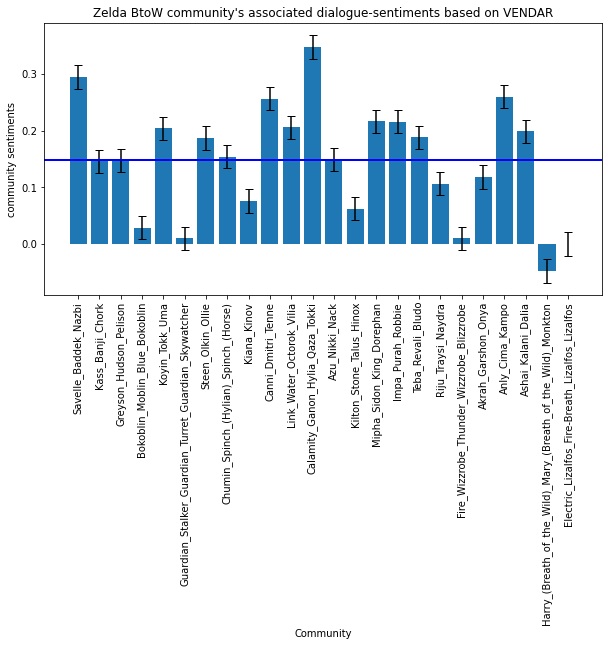

In [795]:
y = np.array(list((vader_sentiments_of_communities).values()))
x = range(len(vader_sentiments_of_communities))

fig, ax = plt.subplots(figsize=(10,5))
# add error bars 
std_error = np.std(y, ddof=1) / np.sqrt(len(y))
ax.bar(x=np.arange(len(y)), #x-coordinates of bars
       height=y, #height of bars
       yerr=std_error, #error bar width
       capsize=4) #length of error bar caps
# add average line
plt.axhline(y=y.mean(), color='blue', linewidth=2)
# add more details
# set xticks by community names
plt.xticks([i for i in range(len(vader_sentiments_of_communities))], communities_name, rotation = '90')
plt.title('Zelda BtoW community\'s associated dialogue-sentiments based on VENDAR')
plt.ylabel('community sentiments')
plt.xlabel('Community')

1. Firsly, Y-axis range is different between the two plots. The reason is that VANDAR has token features rated on a scale from "[–4] Extremely Negative" to "[4] Extremely Positive", with allowance for "[0] Neutral (or Neither, N/A)". In the plot, we use  'normalized, weighted composite score' `compound` between -1 (most extreme negative) and +1 (most extreme positive) to measure community sentiment.Typical threshold values (used in the literature cited on this page) are:1. positive sentiment: compound score >= 0.05 2. neutral sentiment: (compound score > -0.05) and 3. (compound score < 0.05)negative sentiment: compound score <= -0.05. By contrast, labMIT txt rank tokens according to their sentiment scores from 0(negative) to 8.5(postitive).
2. The average sentiment of each community is clearly more centred within plot based on VENDAR. This is because VENDAR kept every lexical feature with the standard deviation doesn't exceed 2.5. Overall, the distribution of this plot is more 'even' than the one based on labMIT. The polarity values are more distinct on VENDAR which is easier to detect. 

### What is the advantage of using a rule-based method over the simple dictionary-based approach?